In [16]:
import numpy as np

from qore import Mine, ASP, QAOA, VQE, Pseudoflow
from qore import ASPSolver, QAOASolver, PseudoflowSolver

from qore.utils import get_bitstring_probabilities

In [2]:
qmine = Mine('mine_config.txt')

# penalty = 20.0
# qmine = Mine(np.array([[-2., 3., 1., -1.], [float('inf'), 5., 3., float('inf')]]))

# penalty = 5.0
# qmine = Mine(np.array([[-2.0, 3.0, -1.0, -2.0, -1.0], [float('inf'), 5.0, 3.0, 10.0, float('inf')], [float('inf'), float('inf'), 4.0, float('inf'), float('inf')]]))

qmine.plot_mine()

+---+--------+-------+-------+
|   |   0    |   1   |   2   |
+---+--------+-------+-------+
| 0 | -2.000 | 3.000 | 1.000 |
| 1 |  inf   | 5.000 |  inf  |
+---+--------+-------+-------+


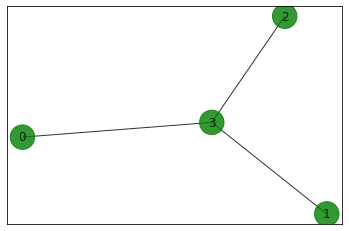

In [5]:
qmine.plot_mine_graph('g')

In [6]:
print(qmine.gen_Hamiltonian(penalty=10.))

-0.0 * IIII
+ 1.0 * IIII
- 1.0 * IIIZ
- 1.5 * IIII
+ 1.5 * IIZI
- 0.5 * IIII
+ 0.5 * IZII
- 2.5 * IIII
+ 2.5 * ZIII
+ 0.0 * IIII
+ 2.5 * IIII
+ 2.5 * IIIZ
- 2.5 * ZIII
- 2.5 * ZIIZ
+ 2.5 * IIII
+ 2.5 * IIZI
- 2.5 * ZIII
- 2.5 * ZIZI
+ 2.5 * IIII
+ 2.5 * IZII
- 2.5 * ZIII
- 2.5 * ZZII


## Pseudoflow

In [8]:
pf = PseudoflowSolver(qmine)
res = pf.solve()
res

{'opt_config': '1111'}

## ASP

In [9]:
asp = ASPSolver(qmine)

In [11]:
penalty = 10.0
evol_time = 20
nsteps = 40

res = asp.solve(penalty, evol_time=evol_time, nsteps=nsteps)

In [12]:
res

{'opt_config': '1111',
 'opt_config_prob': 0.892578125,
 'profit_avg': 6.649905944211189,
 'violation_avg': 0.031190752224617556,
 'ground_state': {'0000': 0.0009765625,
  '0010': 0.001953125,
  '1000': 0.0009765625,
  '1100': 0.0009765625,
  '1010': 0.00390625,
  '1111': 0.892578125,
  '0111': 0.005859375,
  '0100': 0.005859375,
  '0110': 0.0625,
  '1101': 0.0244140625}}

In [22]:
# add a callback function
def analysis(circ):
    x = get_bitstring_probabilities(circ, asp.instance, shots=asp.shots)
    bitstr, prob = max(x.items(), key=lambda item: item[1])
    print(f"The most probable configuration and the corresponding probability: {bitstr, prob}")

In [23]:
res = asp.solve(penalty, evol_time=evol_time, nsteps=nsteps, callback=analysis, callback_freq=5)

The most probable configuration and the corresponding probability: ('0100', 0.0791015625)
The most probable configuration and the corresponding probability: ('1111', 0.1455078125)
The most probable configuration and the corresponding probability: ('1111', 0.251953125)
The most probable configuration and the corresponding probability: ('1111', 0.5458984375)
The most probable configuration and the corresponding probability: ('1111', 0.861328125)
The most probable configuration and the corresponding probability: ('1111', 0.861328125)
The most probable configuration and the corresponding probability: ('1111', 0.892578125)
The most probable configuration and the corresponding probability: ('1111', 0.904296875)


## QAOA

In [24]:
qaoa = QAOASolver(qmine, p=3)

In [25]:
penalty = 10.0

res = qaoa.solve(penalty)

In [26]:
res

{'opt_config': '1111',
 'opt_config_prob': 0.404296875,
 'profit_avg': 5.20357894588849,
 'violation_avg': 0.1645232640922789,
 'ground_state': {'1001': 0.0048828125,
  '1000': 0.00390625,
  '1011': 0.013671875,
  '0101': 0.025390625,
  '1010': 0.0068359375,
  '0010': 0.0146484375,
  '0000': 0.0244140625,
  '1100': 0.0009765625,
  '0100': 0.013671875,
  '0110': 0.244140625,
  '0001': 0.0029296875,
  '0011': 0.0322265625,
  '1101': 0.0009765625,
  '1111': 0.404296875,
  '0111': 0.119140625,
  '1110': 0.087890625}}